# VCF - Parametric low-pass filter

A low pass filter where the following parameters are independently controllable:

- Cutoff frequency
- Resonance

In [1]:
from numpy import *
from matplotlib.pyplot import *
from scipy import signal
import scipy.io.wavfile
from numba import jit

In [34]:
class Simulator(object):
    def __init__(self, amplitude=2**15-1, yrange=[-50, 10]):
        self.amplitude = amplitude
        self.yrange = yrange
        
        self.fig, self.ax1 = subplots(1, 1, figsize=[8, 4])
        
        # Load/generate data files
        self.sample_rate_Hz = 44100
        fs, x = scipy.io.wavfile.read("../app/sound/prbs20.wav")
        assert(fs == self.sample_rate_Hz)
        self.x_prbs20 = self.amplitude * x/(2**15)
        
        t = arange(len(self.x_prbs20)) / self.sample_rate_Hz
        self.x_chirp = self.amplitude * signal.chirp(t, f0=20, f1=20e3, t1=max(t), method="linear")
    
    def vcf(self, x, cutoff, resonance):
        # Example filter
        b, a = signal.cheby1(2, 10, 1000 * 2/self.sample_rate_Hz, btype="low")
        return signal.lfilter(b, a, x)
    
    def simulate_chirp(self, cutoff, resonance):
        y = self.vcf(self.x_chirp, cutoff, resonance)
        
        f = linspace(20, 20e3, len(y))
        #H = 1/self.amplitude * y
        H = 1/self.amplitude * signal.hilbert(y)

        label = "cutoff={:.0f}, resonance={:.0f}".format(cutoff, resonance)
        self.plot_frequency_response(f, H, label=label)
        return 
    
    def simulate_prbs(self, cutoff, resonance, h_length=None):
        x = self.x_prbs20
        y = self.vcf(x, cutoff, resonance)
        
        if h_length is None:
            h_length = int(30/cutoff)

        t, h, f, H = self.analyze_prbs(x, y, h_length)
        label = "cutoff={:.0f}, resonance={:.0f}".format(cutoff, resonance)
        self.plot_frequency_response(f, H, label=label)
    
    def analyze_prbs(self, x, y, h_length):
        # Estimate impulse response using a pseudo-random bit sequence.
        h = signal.correlate(y, x, "full")
        h = h[len(h)//2:]

        # Limit the impulse response length to lower the noise
        h = h[0:h_length]
        t = arange(h_length)/self.sample_rate_Hz

        # Estimate frequency response
        H = fft.fft(h)
        H = H[0:len(H)//2] 
        H /= max(abs(H))
        f = linspace(0.01, self.sample_rate_Hz/2, len(H))

        return t, h, f, H

    def plot_frequency_response(self, f, H, label=None):
        self.ax1.semilogx(f, 20*ma.log10(abs(H)), label=label)

    def show(self):
        # Frequency response graph
        self.ax1.grid(True, "both", "both")
        self.ax1.legend()
        self.ax1.set_xlim(20, 20e3)
        self.ax1.set_ylim(*self.yrange)
        
        self.fig.tight_layout()
        #self.fig.show()


## Stilson and Smith 1996 Analyzing the Moog VCF with Considerations for Digital Implementation

Non-saturating filter with decoupled cutoff and resonance. Note that high resonances are not dampened and may cause overflow.

- Referred to in Valimaki 2006 Oscillator and Filter Algorithms for Virtual Analog Synthesis page 26.
- Here, a block diagram of the compromise onepole is shown.

In [54]:
@jit
def nb_onepole(x, g, x1, y1):
    v = 1/1.3 * x + 0.3/1.3*x1
    y = (v-y1)*g + y1
    return y

@jit
def nb_vcf(x, g, k):
    # Onepole delay points:
    # - Before op1
    # - After opN for N in 1...4
    y = [0]*len(x)
    w = [0, 0, 0, 0, 0] # Current sample
    d = [0, 0, 0, 0, 0] # Delayed sample

    for n in range(1, len(y)):
        w[0] = x[n] - d[4]*k
        #w[0] = 2**15 * tanh(w[0]/2**15)
        w[1] = nb_onepole(w[0], g, d[0], d[1])
        w[2] = nb_onepole(w[1], g, d[1], d[2])
        w[3] = nb_onepole(w[2], g, d[2], d[3])
        w[4] = nb_onepole(w[3], g, d[3], d[4])

        for i in range(5):
            d[i] = w[i]

        y[n] = w[4]

    return y

class VoltageControlledFilter(Simulator):
    def map_cutoff(self, value):
        assert(0 <= value <= 127)
        b = 0.02
        a = (0.8-b) / (127*127)
        return a*value*value + b

    def map_resonance(self, value):
        assert(0 <= value <= 127)
        b = 0.5
        a = (3.9-b) / 127
        return a*value + b
 
    def vcf(self, x, cutoff, resonance):
        g = self.map_cutoff(cutoff)
        k = self.map_resonance(resonance)
        y = nb_vcf(x, g, k)
        return y

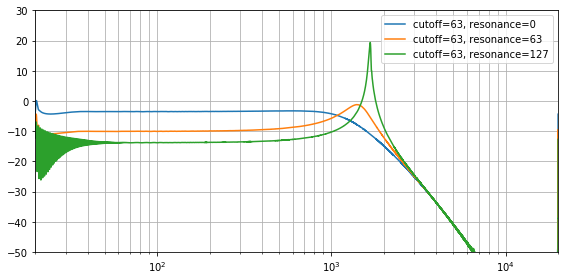

In [55]:
s = VoltageControlledFilter(yrange=[-50, 30])
for res in [0, 63, 127]:
    s.simulate_chirp(63, res)
s.show()

## Peak limiter

- Lyons 2011 Understanding digital signal processing Section 13.30.
- [SMOOTHING OF THE CONTROL SIGNAL WITHOUT CLIPPED OUTPUT IN DIGITAL PEAK LIMITERS](https://users.aalto.fi/~hamalap5/dafx2002/dafx_hamalainen.pdf)

In [44]:
@jit
def detector(x, a):
    e = [0]*len(x)
    
    for n in range(1, len(x)):
        e[n] = a*abs(x[n]) + (1-a)*e[n-1]
    
    return e
        

/home/soren/.local/lib/python3.6/site-packages/numba/ir_utils.py:1958: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'x' of function 'detector'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-44-4a8586f20641>", line 2:
@jit
def detector(x, a):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


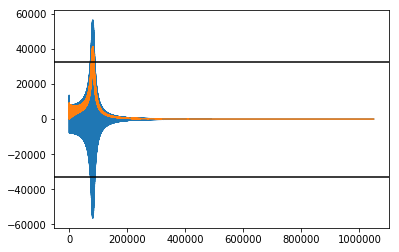

In [45]:
s = VoltageControlledFilter(yrange=[-50, 30])
close()

y = s.vcf(s.x_chirp, cutoff=63, resonance=100)
env = detector(y, 0.1)

plot(y)
plot(env)
axhline(s.amplitude, color="k")
axhline(-s.amplitude, color="k")